<a href="https://colab.research.google.com/github/Giyoung-Kwon/causality_hw3/blob/main/IV_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LATE Estimation Tutorial

This tutorial gives a short example for how to use instrument variable to estimate local average treatment effect using machine learning methods

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import math

In [2]:
RANDOM_SEED=0
np.random.seed(RANDOM_SEED)

##Load Outvote 2020 Observational Data

First, load the observational data.

In [11]:
outvote = pd.read_csv('https://raw.githubusercontent.com/vveitch/causality-tutorials/main/data/outvote_2020_data.csv')
outvote

,voted_2020,messaged,queue_position,queue_length,queue_id,voted_2018,voted_2016,is_Democrat,is_Republican,is_Male,is_Female,is_Married,is_Urban,is_Rural,is_Battleground,age
0,1,1,1.0,19.0,xgcwm279xcwkxjq4zxabo,0,0,0,0,0,1,0,0,0,1,68.0
1,1,1,6.0,19.0,xgcwm279xcwkxjq4zxabo,1,1,1,0,1,0,0,0,0,0,52.0
2,0,1,8.0,19.0,xgcwm279xcwkxjq4zxabo,1,0,1,0,0,1,0,0,0,0,26.0
3,1,1,10.0,19.0,xgcwm279xcwkxjq4zxabo,1,1,0,0,1,0,0,0,0,1,39.0
4,1,1,18.0,19.0,xgcwm279xcwkxjq4zxabo,0,1,1,0,0,1,0,0,0,1,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81199,1,0,5.0,5.0,0j3f3gyc3qspaukludfcpy4,1,1,0,0,0,1,1,0,0,1,54.0
81200,1,0,2.0,3.0,ixyu0l548p9dextzgjspdr,0,1,0,0,0,1,0,0,0,0,36.0
81201,0,0,1.0,2.0,ghclqszfr6qvz2i5yesrwo,0,1,0,0,0,1,0,0,0,1,90.0
81202,1,1,2.0,9.0,sscqhe1ttlh7fmkmuk231f,1,1,0,0,1,0,1,0,0,1,72.0


**Data description:**
* Core variables:
  * `voted_2020`: (binary) the outcome; whether subject voted in 2020 election
  * `messaged`: (binary) the treatment; whether subject was messaged by an Outvote user
  * `queue_position`: (ordinal / pos int / 1+) the instrument; the subject's position/ranking in the user's queue; this is randomized
  * `queue_length`: (ordinal / pos int / 2+) the block; how long the user's queue was; this is endogenous / non-randomized and must be blocked on

* Optional / additional variables:
  * `queue_id`: (int) a unique identifier for the queue the subject was in
  * `voted_2018`: (binary) whether subject voted in 2018 election
  * `voted_2016`: (binary) whether subject voted in 2016 election
  * `is_Democrat`: (binary) whether subject is registered Democrat
  * `is_Republican`: (binary) whether subject is registered Republican
  * `is_Male`: (binary) whether subject identifies as Male
  * `is_Female`: (binary) whether subject identifies as Female
  * `is_Married`: (binary) whether subject is married
  * `is_Urban`: (binary) whether subject lives in a city
  * `is_Rural`: (binary) whether subject lives in a rural area
  * `is_Battleground`: (binary) whether subject is registered in a battleground state
  * `age`: (pos int, 18+), subject's age

## Homework: 2SLS Estimation

In [12]:
import statsmodels.api as sm
!pip install -q linearmodels
from linearmodels.iv import IV2SLS

# 1) Prepare variables
y   = outvote['voted_2020']                        # outcome
A   = outvote['messaged']                         # endogenous regressor
Z   = outvote['queue_position']                   # instrument
L   = sm.add_constant(outvote['queue_length'])    # controls (including constant)

# 2) Specify & fit IV2SLS
iv_model = IV2SLS(dependent=y,
                  exog=L,
                  endog=A,
                  instruments=Z)
iv_res   = iv_model.fit(cov_type='robust')   # robust SEs

# 3) Display
print(iv_res.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:             voted_2020   R-squared:                     -0.0003
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0003
No. Observations:               81204   F-statistic:                    1.1046
Date:                Wed, May 21 2025   P-value (F-stat)                0.5756
Time:                        00:39:11   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
const            0.7786     0.0255     30.565     0.0000      0.7287      0.8286
queue_length -5.727e-06  2.446e-05    -0.234

In [13]:
# select a cutoff K = 37 for the instrument
# we only consider those queues with length > K
outvote = outvote.loc[outvote.queue_length>37].reset_index()
outvote['queue_position'] = (outvote['queue_position'] <= 37.0).astype(int)
len(outvote)

43357

In [14]:
outcome = outvote['voted_2020']
treatment = outvote['messaged']
instrument = outvote['queue_position']
block = outvote['queue_length']

## Specify Nuisance Function Models

The next step is to specify models for

*   $\mu(z,x)=\mathbb{E}(Y|z,x)$
*   $m(z,x) = P(A=1|z,x)$
*   $p(x) = P(Z=1|x)$



## HW: New Models

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

def make_mu_model():
  return GradientBoostingClassifier(
    n_estimators=100,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=5,
    learning_rate=0.1,
    random_state=RANDOM_SEED
  )
mu_model = make_mu_model()

def make_m_model():
  return RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_SEED
  )
m_model = make_m_model()

# Logistic Regression p model
def make_p_model():
  return LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=100,
    random_state=RANDOM_SEED
  )
p_model = make_p_model()

# Random forest p model
def make_p_model():
  return RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_SEED)
p_model = make_p_model()

In [30]:
from sklearn.neighbors import KNeighborsClassifier
# specify a model for mu(z,x)

# make a function that returns a sklearn model for later use in k-folding
# def make_mu_model():
#   return KNeighborsClassifier(n_neighbors=300)
# mu_model = make_mu_model()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation

X_zx = outvote[['queue_position','queue_length']].copy()

X_train, X_test, y_train, y_test = train_test_split(X_zx, outcome, test_size=0.2)
mu_model.fit(X_train, y_train)
y_pred = mu_model.predict_proba(X_test)[:,1]

test_ce=log_loss(y_test, y_pred)
print(f"Test Cross Entropy of fit model {test_ce}")
baseline_ce=log_loss(y_test, y_train.mean()*np.ones_like(y_test))
print(f"Test Cross Entropy of no-covariate model {baseline_ce}")

Test Cross Entropy of fit model 0.5245313015282094
Test Cross Entropy of no-covariate model 0.5316974024050836


In [31]:
# specify a model for m(z,x)

# def make_m_model():
#   return LogisticRegression(max_iter=1000, warm_start=True, random_state=RANDOM_SEED)

# m_model = make_m_model()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation

X_train, X_test, a_train, a_test = train_test_split(X_zx, treatment, test_size=0.2)
m_model.fit(X_train, a_train)
a_pred = m_model.predict_proba(X_test)[:,1]

test_ce=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce}")
baseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce}")

Test CE of fit model 0.6325403272309031
Test CE of no-covariate model 0.670016330909448


In [32]:
# def make_p_model():
#   return RandomForestClassifier(n_estimators=200, max_depth=5)

# p_model = make_p_model()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation

X_train, X_test, Z_train, Z_test = train_test_split(block.to_frame(), instrument, test_size=0.2)
p_model.fit(X_train, Z_train)
Z_pred = p_model.predict_proba(X_test)[:,1]

test_ce=log_loss(Z_test, Z_pred)
print(f"Test CE of fit model {test_ce}")
baseline_ce=log_loss(Z_test, Z_train.mean()*np.ones_like(Z_test))
print(f"Test CE of no-covariate model {baseline_ce}")

Test CE of fit model 0.5365043811517166
Test CE of no-covariate model 0.681076922731655


## Use cross fitting to get predicted $\hat{\mu}$, $\hat{m}$, $\hat{p}$ for each unit

In [33]:
# helper functions to implement the cross fitting

def p_k_fold_fit_and_predict(make_model, X:pd.DataFrame, Z:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the instrument Z.
    That is,
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    Z: array of instruments
    n_splits: number of splits to use
    """
    predictions = np.full_like(Z, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    for train_index, test_index in kf.split(X, Z):
      X_train = X.loc[train_index]
      Z_train = Z.loc[train_index]
      g = make_model()
      g.fit(X_train, Z_train)

      # get predictions for split
      predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]

    assert np.isnan(predictions).sum() == 0
    return predictions


def m_k_fold_fit_and_predict(make_model, X:pd.DataFrame, Z:np.array, A:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the outcome Y.
    That is,
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    Z: array of instruments
    A: array of treatments
    n_splits: number of splits to use
    """
    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_zx = X.copy()
    X_zx["Z"] = Z

    # for predicting A under Z=1 / Z=0 status for each data point
    X0 = X_zx.copy()
    X0["Z"] = 0
    X1 = X_zx.copy()
    X1["Z"] = 1

    for train_index, test_index in kf.split(X_zx, A):
      X_train = X_zx.loc[train_index]
      A_train = A.loc[train_index]
      m = make_model()
      m.fit(X_train, A_train)
      predictions0[test_index] = m.predict_proba(X0.loc[test_index])[:,1]
      predictions1[test_index] = m.predict_proba(X1.loc[test_index])[:,1]

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

def mu_k_fold_fit_and_predict(make_model, X:pd.DataFrame, Z:np.array, y:np.array, n_splits:int, output_type:str):
    """
    Implements K fold cross-fitting for the model predicting the outcome Y.
    That is,
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    Z: array of instruments
    y: array of outcomes
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"

    """
    predictions0 = np.full_like(y, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
      kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
      kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_zx = X.copy()
    X_zx["Z"] = Z

    # for predicting effect under treatment / control status for each data point
    X0 = X_zx.copy()
    X0["Z"] = 0
    X1 = X_zx.copy()
    X1["Z"] = 1


    for train_index, test_index in kf.split(X_zx, y):
      X_train = X_zx.loc[train_index]
      y_train = y.loc[train_index]
      mu = make_model()
      mu.fit(X_train, y_train)

      if output_type =='binary':
        predictions0[test_index] = mu.predict_proba(X0.loc[test_index])[:, 1]
        predictions1[test_index] = mu.predict_proba(X1.loc[test_index])[:, 1]
      elif output_type == 'continuous':
        predictions0[test_index] = mu.predict(X0.loc[test_index])
        predictions1[test_index] = mu.predict(X1.loc[test_index])

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

In [34]:
p = p_k_fold_fit_and_predict(make_p_model, X=block.to_frame(), Z=instrument, n_splits=10)

In [35]:
m0,m1= m_k_fold_fit_and_predict(make_m_model, X=block.to_frame(), Z=instrument, A=treatment, n_splits=10)

(array([13.20141426,  1.26840927,  8.57891556,  2.46759946,  0.03825265,
         0.05525383,  0.18458421,  0.35702473,  0.04128857,  0.13297349]),
 array([0.0811496 , 0.11913527, 0.15712094, 0.19510661, 0.23309228,
        0.27107795, 0.30906362, 0.3470493 , 0.38503497, 0.42302064,
        0.46100631]),
 <BarContainer object of 10 artists>)

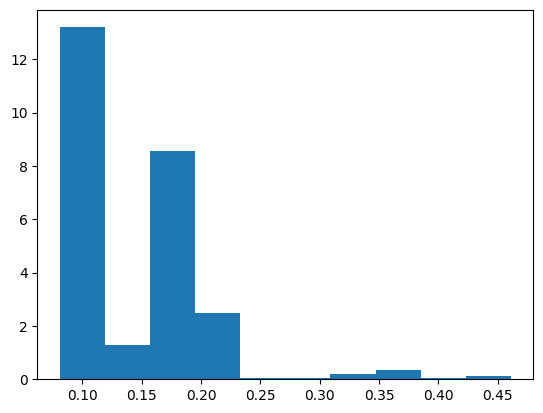

In [36]:
# check relevance
from matplotlib.pyplot import hist
hist(m1-m0, density=True)

In [37]:
mu0,mu1= mu_k_fold_fit_and_predict(make_mu_model, X=block.to_frame(), Z=instrument, y=outcome, n_splits=10, output_type="binary")

In [38]:
data_and_nuisance_estimates = pd.DataFrame({'p': p, 'mu0': mu0, 'mu1': mu1, 'm1': m1, 'm0': m0,
                                            'Z': instrument, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates.head()

,p,mu0,mu1,m1,m0,Z,A,Y
0,0.147769,0.788863,0.833510,0.675426,0.512434,0,0,0
1,0.145855,0.778322,0.801244,0.675038,0.512392,0,0,1
2,0.136069,0.789427,0.800566,0.672884,0.512178,0,0,1
3,0.145855,0.776586,0.776586,0.677179,0.509403,0,0,1
4,0.136069,0.781052,0.818124,0.677338,0.509714,0,0,0


## Combine predicted values and data into estimate of LATE

In [39]:
def late_estimator(mu1, mu0, m1, m0, p, Z, A, Y, prob = None):
  '''
  Estimator for LATE
  '''
  n = len(Y)
  phi_zy = mu1 - mu0 + Z*(Y-mu1)/p - (1-Z)*(Y-mu0)/(1-p)
  phi_za = m1 - m0 + Z*(A-m1)/p - (1-Z)*(A-m0)/(1-p)

  tau_za = phi_za.mean()
  tau_hat = phi_zy.mean()/tau_za
  phi = phi_zy - phi_za * tau_hat

  std_hat = math.sqrt((phi**2).mean()/tau_za**2/n)

  return tau_hat, std_hat


In [40]:
tau_hat, std_hat = late_estimator(**data_and_nuisance_estimates)
print(f"The estimate is {tau_hat} pm {1.96*std_hat}")

The estimate is 0.05297061803584156 pm 0.06585275742917977
